In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip -q install scikit-learn>=1.3 xgboost lightgbm tensorflow==2.* scikeras

In [ ]:
# Cell 2: Imports & Utility Functions
# -----------------------------------
import os
import numpy as np
import pandas as pd

from typing import List, Optional

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# NSE (Nash-Sutcliffe Efficiency)
def nse_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

# RMSE
# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  # works in all sklearn versions


# "Accuracy" for regression — we'll report R2*100 as Accuracy%, matching the paper's style.
def regression_accuracy_percent(y_true, y_pred):
    return max(0.0, r2_score(y_true, y_pred)) * 100

# Nicely print metrics
def print_metrics(y_true, y_pred, label=""):
    _rmse = rmse(y_true, y_pred)
    _r2 = r2_score(y_true, y_pred)
    _nse = nse_score(y_true, y_pred)
    _acc = regression_accuracy_percent(y_true, y_pred)
    print(f"{label}RMSE: {_rmse:,.3f} | R²: {_r2:.4f} | NSE: {_nse:.4f} | Accuracy% (R²*100): {_acc:.2f}%")


In [ ]:
# Cell 3: Load Data
# -----------------
CSV_PATH = "/content/drive/MyDrive/cotton_growth_cycle_data.csv"
assert os.path.exists(CSV_PATH), f"File not found: {CSV_PATH}"

df_raw = pd.read_csv(CSV_PATH)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (80000, 17)


,Farm_ID,Planting_Date,Harvest_Date,Growth_Cycle,Yield,Sunlight_Hours,Precipitation,Average_Temperature,Drought_Days,Flood_Days,Soil_Moisture,Soil_pH,CO2_Concentration,Harvest_Year,Sunlight_Level,Flood_Level,Drought_Level
0,1,2014-06-10,2014-09-18,100,205,4.59,603,23,57,48,49,6.05,429,2014,Low,Severe,Severe
1,2,2023-03-29,2023-08-18,142,250,6.96,478,15,27,98,85,5.45,437,2023,Medium Low,Extreme,Mild
2,4,2015-11-24,2016-03-04,101,273,9.93,497,26,70,29,59,4.75,421,2016,Medium High,Moderate,Extreme
3,5,2017-01-19,2017-05-08,109,244,5.02,316,19,28,26,80,5.83,413,2017,Medium Low,Moderate,Moderate
4,6,2021-02-05,2021-06-14,129,293,10.15,414,26,60,24,82,6.53,409,2021,Medium High,Mild,Severe


In [ ]:
# Cell 4: Basic Cleaning (drop duplicates, handle obvious NaNs)
# -------------------------------------------------------------
df = df_raw.copy()

# Drop exact duplicates
df = df.drop_duplicates()

# Strip column names
df.columns = [c.strip() for c in df.columns]

# Common target name guesses; adjust if your file uses different naming
TARGET_CANDIDATES = ["yield", "Yield", "lint_yield", "LintYield", "Yield_kg_ha", "yield_kg_ha"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError(
        "Couldn't find a yield column. Please rename your target to one of: "
        + ", ".join(TARGET_CANDIDATES)
    )

print("Detected target column:", target_col)

# Remove rows with missing target
df = df[~df[target_col].isna()].reset_index(drop=True)

print("After cleaning:", df.shape)
df.head()


Detected target column: Yield
After cleaning: (80000, 17)


,Farm_ID,Planting_Date,Harvest_Date,Growth_Cycle,Yield,Sunlight_Hours,Precipitation,Average_Temperature,Drought_Days,Flood_Days,Soil_Moisture,Soil_pH,CO2_Concentration,Harvest_Year,Sunlight_Level,Flood_Level,Drought_Level
0,1,2014-06-10,2014-09-18,100,205,4.59,603,23,57,48,49,6.05,429,2014,Low,Severe,Severe
1,2,2023-03-29,2023-08-18,142,250,6.96,478,15,27,98,85,5.45,437,2023,Medium Low,Extreme,Mild
2,4,2015-11-24,2016-03-04,101,273,9.93,497,26,70,29,59,4.75,421,2016,Medium High,Moderate,Extreme
3,5,2017-01-19,2017-05-08,109,244,5.02,316,19,28,26,80,5.83,413,2017,Medium Low,Moderate,Moderate
4,6,2021-02-05,2021-06-14,129,293,10.15,414,26,60,24,82,6.53,409,2021,Medium High,Mild,Severe


In [ ]:
# Cell 5: Accumulated Heat (AH) handling per paper
# ------------------------------------------------
# The paper uses Accumulated Heat (DD60). We'll try to compute it if daily min/max temps exist.
# Otherwise, we'll use an existing column if present.

# Possible names for accumulated heat provided
AH_CANDIDATES = ["AccumulatedHeat", "accumulated_heat", "AH", "DD60", "dd60", "heat_units"]
ah_col = None
for c in AH_CANDIDATES:
    if c in df.columns:
        ah_col = c
        break

# If AH not present, try to compute from daily temps if your CSV has daily columns like tmin_d1 ... tmin_dN, tmax_d1 ... tmax_dN.
# If your dataset has a long format (date rows per plot), you'd need to pre-aggregate per plot before this step.
daily_tmin_cols = [c for c in df.columns if c.lower().startswith("tmin_d")]
daily_tmax_cols = [c for c in df.columns if c.lower().startswith("tmax_d")]
daily_tmin_cols = sorted(daily_tmin_cols)
daily_tmax_cols = sorted(daily_tmax_cols)

def compute_dd60_from_daily_row(row):
    # DD60 per day = ((Fmax + Fmin)/2) - 60 ; clamp negative to 0.
    # If temps are in Celsius, convert to Fahrenheit first. We'll try to infer units by magnitude.
    # If data looks like Celsius typical range (<=50), assume C; else F.
    dd60_sum = 0.0
    for tmin_col, tmax_col in zip(daily_tmin_cols, daily_tmax_cols):
        tmin = row[tmin_col]
        tmax = row[tmax_col]
        if pd.isna(tmin) or pd.isna(tmax):
            continue
        # Infer units
        if max(tmin, tmax) <= 60:  # likely Celsius
            fmin = tmin * 9/5 + 32
            fmax = tmax * 9/5 + 32
        else:
            fmin = tmin
            fmax = tmax
        dd60 = ((fmax + fmin) / 2.0) - 60.0
        if dd60 < 0:
            dd60 = 0.0
        dd60_sum += dd60
    return dd60_sum

if ah_col is None:
    if daily_tmin_cols and daily_tmax_cols and (len(daily_tmin_cols) == len(daily_tmax_cols)):
        df["AccumulatedHeat"] = df.apply(compute_dd60_from_daily_row, axis=1)
        ah_col = "AccumulatedHeat"
        print("Computed AccumulatedHeat from daily min/max temps.")
    else:
        print("No AccumulatedHeat column found and cannot compute from daily temps.")
        print("Proceeding WITHOUT AH (model will still run, but consider adding AH for best results).")

print("AH column used:", ah_col)


No AccumulatedHeat column found and cannot compute from daily temps.
Proceeding WITHOUT AH (model will still run, but consider adding AH for best results).
AH column used: None


In [ ]:
# Cell 6: Identify Key Feature Columns (Nitrogen, Soil, Cultivar, etc.)
# ---------------------------------------------------------------------
# We'll try to guess typical column names. Adjust the lists below if needed.

N_CANDIDATES = ["Nitrogen", "nitrogen", "N", "N_kg_ha", "nitrogen_kg_ha"]
SOIL_CANDIDATES = ["soil_type", "SoilType", "soil", "Soil"]
CULTIVAR_CANDIDATES = ["cultivar", "Cultivar", "variety", "Variety"]

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

nitrogen_col = pick_col(df, N_CANDIDATES)
soil_col = pick_col(df, SOIL_CANDIDATES)
cultivar_col = pick_col(df, CULTIVAR_CANDIDATES)

print("Detected columns -> Nitrogen:", nitrogen_col, "| Soil:", soil_col, "| Cultivar:", cultivar_col)

# Build feature list
feature_cols = []
if ah_col is not None:
    feature_cols.append(ah_col)
if nitrogen_col is not None:
    feature_cols.append(nitrogen_col)

# Include any other helpful numeric columns (weather summaries, etc.) except the target
numeric_extra = [
    c for c in df.columns
    if c not in (feature_cols + [target_col]) and
       df[c].dtype != 'O' and            # exclude object
       not c.lower().startswith("tmin_d") and
       not c.lower().startswith("tmax_d")
]
feature_cols += numeric_extra

# Add categoricals (soil, cultivar)
categorical_cols = [c for c in [soil_col, cultivar_col] if c is not None]

print("Final numeric features:", feature_cols)
print("Final categorical features:", categorical_cols)


Detected columns -> Nitrogen: None | Soil: None | Cultivar: None
Final numeric features: ['Farm_ID', 'Growth_Cycle', 'Sunlight_Hours', 'Precipitation', 'Average_Temperature', 'Drought_Days', 'Flood_Days', 'Soil_Moisture', 'Soil_pH', 'CO2_Concentration', 'Harvest_Year']
Final categorical features: []


In [ ]:
# Cell 7: Outlier Removal (IQR) for Accumulated Heat & Nitrogen as in the paper
# ------------------------------------------------------------------------------
# We’ll remove outliers for AH and Nitrogen ONLY (as per the document).
# If they’re missing, this step just skips those columns.

df_pre = df.copy()

def remove_iqr_outliers(dfin, cols: List[str], k: float = 1.5):
    dfout = dfin.copy()
    for col in cols:
        if (col is None) or (col not in dfout.columns):
            continue
        if not np.issubdtype(dfout[col].dtype, np.number):
            continue
        Q1 = dfout[col].quantile(0.25)
        Q3 = dfout[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        before = dfout.shape[0]
        dfout = dfout[(dfout[col] >= lower) & (dfout[col] <= upper)]
        after = dfout.shape[0]
        print(f"Removed {before - after} outliers from {col}")
    return dfout

df_pre = remove_iqr_outliers(df_pre, [ah_col, nitrogen_col], k=1.5)
df_pre = df_pre.reset_index(drop=True)
print("After outlier removal:", df_pre.shape)


After outlier removal: (80000, 17)


In [ ]:
# Cell 8: Train/Test Split
# ------------------------
X = df_pre[feature_cols + categorical_cols].copy()
y = df_pre[target_col].copy().astype(float)

# Simple 80/20 split (paper style)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train.shape, X_test.shape


((64000, 11), (16000, 11))

In [ ]:
# Cell 9: Preprocess Pipeline (Encode categoricals, Scale numerics)
# -----------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder

numeric_cols = [c for c in feature_cols if c in X_train.columns]
cat_cols = [c for c in categorical_cols if c in X_train.columns]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# Fit the preprocessor
preprocessor.fit(X_train)

# Transform data
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Transformed shapes ->", X_train_p.shape, X_test_p.shape)


Transformed shapes -> (64000, 11) (16000, 11)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 10: Strong Deep Learning Model (Keras MLP with regularization)
# -------------------------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

input_dim = X_train_p.shape[1]

def build_mlp(input_dim: int):
    keras.utils.set_random_seed(42)
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(1, activation="linear")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

mlp = build_mlp(input_dim)

es = callbacks.EarlyStopping(monitor="val_rmse", patience=20, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5, patience=8, min_lr=1e-5, verbose=1)

history = mlp.fit(
    X_train_p, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=0
)

print("Best val RMSE:", min(history.history["val_rmse"]))



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Best val RMSE: 10.203118324279785


In [ ]:
# Cell 11: Evaluate Deep Learning Model
# -------------------------------------
y_pred_dl = mlp.predict(X_test_p).ravel()
print_metrics(y_test, y_pred_dl, label="[Deep Learning MLP] ")


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Deep Learning MLP] RMSE: 10.253 | R²: 0.9001 | NSE: 0.9001 | Accuracy% (R²*100): 90.01%


In [ ]:
# Cell 12 (Optional but recommended): Baseline Tree Models for Comparison
# -----------------------------------------------------------------------
# Helps prove your DL model is strong (try to beat or match these).

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_p, y_train)
y_pred_rf = rf.predict(X_test_p)
print_metrics(y_test, y_pred_rf, label="[RandomForest] ")

lgbm = lgb.LGBMRegressor(
    n_estimators=1500,
    num_leaves=64,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_train_p, y_train, eval_set=[(X_test_p, y_test)], eval_metric="rmse")
y_pred_lgbm = lgbm.predict(X_test_p)
print_metrics(y_test, y_pred_lgbm, label="[LightGBM] ")

[RandomForest] RMSE: 4.668 | R²: 0.9793 | NSE: 0.9793 | Accuracy% (R²*100): 97.93%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 11
[LightGBM] [Info] Start training from score 254.481156


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] RMSE: 2.711 | R²: 0.9930 | NSE: 0.9930 | Accuracy% (R²*100): 99.30%


In [ ]:
# Cell 14: Feature Importance (Tree Models) + Permutation Importance (DL)
# ------------------------------------------------------------------------
# Tree importances (quick insight). For DL, use permutation importance on preprocessed features.

from sklearn.inspection import permutation_importance

# Get feature names after preprocessing
# For OneHotEncoder, we can extract categories to build final names.
cat_feature_names = []
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_["cat"]
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    cat_feature_names = ohe_names

final_feature_names = []
final_feature_names += numeric_cols
final_feature_names += cat_feature_names

# Tree-based importance
if 'rf' in globals():
    importances = rf.feature_importances_
    fi = pd.DataFrame({"feature": final_feature_names, "importance": importances}).sort_values("importance", ascending=False)
    print("RandomForest feature importance (top 15):")
    display(fi.head(15))

# Permutation importance for DL (on a subset for speed)
perm = permutation_importance(
    estimator=mlp,
    X=X_test_p, y=y_test,
    n_repeats=5, random_state=42, scoring="neg_root_mean_squared_error"
)
perm_df = pd.DataFrame({
    "feature": final_feature_names,
    "perm_importance": perm.importances_mean
}).sort_values("perm_importance", ascending=False)

print("DL permutation importance (top 15):")
perm_df.head(15)


RandomForest feature importance (top 15):


,feature,importance
2,Sunlight_Hours,0.528849
5,Drought_Days,0.193921
6,Flood_Days,0.187186
1,Growth_Cycle,0.045981
3,Precipitation,0.026814
9,CO2_Concentration,0.008739
0,Farm_ID,0.002020
8,Soil_pH,0.001973
7,Soil_Moisture,0.001829
4,Average_Temperature,0.001482


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━

,feature,perm_importance
2,Sunlight_Hours,23.574151
5,Drought_Days,13.386072
6,Flood_Days,12.953897
1,Growth_Cycle,5.967742
9,CO2_Concentration,0.686040
4,Average_Temperature,0.000083
10,Harvest_Year,-0.001363
3,Precipitation,-0.001754
8,Soil_pH,-0.002945
0,Farm_ID,-0.003122


In [ ]:
# Cell 15: Save Artifacts (Preprocessor + DL Model) to Drive
# -----------------------------------------------------------
import joblib

ARTIFACT_DIR = "/content/drive/MyDrive/cotton_yield_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Save preprocessor
joblib.dump(preprocessor, os.path.join(ARTIFACT_DIR, "preprocessor.joblib"))

# Save model
mlp.save(os.path.join(ARTIFACT_DIR, "mlp_cotton_yield.h5"))

# Save a small README with metrics
with open(os.path.join(ARTIFACT_DIR, "README.txt"), "w") as f:
    f.write("Cotton Yield Model Artifacts\n")
    f.write("===========================\n")
    y_pred_dl = mlp.predict(X_test_p).ravel()
    f.write(f"Test RMSE: {rmse(y_test, y_pred_dl):.3f}\n")
    f.write(f"Test R2: {r2_score(y_test, y_pred_dl):.4f}\n")
    f.write(f"Test NSE: {nse_score(y_test, y_pred_dl):.4f}\n")
    f.write(f"Test Accuracy% (R2*100): {regression_accuracy_percent(y_test, y_pred_dl):.2f}%\n")

print("Saved to:", ARTIFACT_DIR)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved to: /content/drive/MyDrive/cotton_yield_artifacts


In [ ]:
# Cell 16: Single-Prediction Inference Example
# --------------------------------------------
# Example: take first test row, predict back.

sample = X_test.iloc[[0]]
sample_p = preprocessor.transform(sample)
pred = mlp.predict(sample_p).ravel()[0]
print("Sample true:", y_test.iloc[0])
print("Sample pred:", float(pred))
print("Sample input (pre-encoded):")
sample


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Sample true: 270.0
Sample pred: 271.59222412109375
Sample input (pre-encoded):


,Farm_ID,Growth_Cycle,Sunlight_Hours,Precipitation,Average_Temperature,Drought_Days,Flood_Days,Soil_Moisture,Soil_pH,CO2_Concentration,Harvest_Year
47044,48765,166,4.4,542,29,23,17,88,5.76,425,2017


In [ ]:
print("Numerical features:", feature_cols)
print("Categorical features:", categorical_cols)

Numerical features: ['Farm_ID', 'Growth_Cycle', 'Sunlight_Hours', 'Precipitation', 'Average_Temperature', 'Drought_Days', 'Flood_Days', 'Soil_Moisture', 'Soil_pH', 'CO2_Concentration', 'Harvest_Year']
Categorical features: []


In [ ]:
# Removing outlier
target_col = "Yield"   # our target variable

# Save original before outlier removal
df_before = df.copy()

# Calculate IQR
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df_after = df[~((df[target_col] < (Q1 - 1.5 * IQR)) | (df[target_col] > (Q3 + 1.5 * IQR)))]


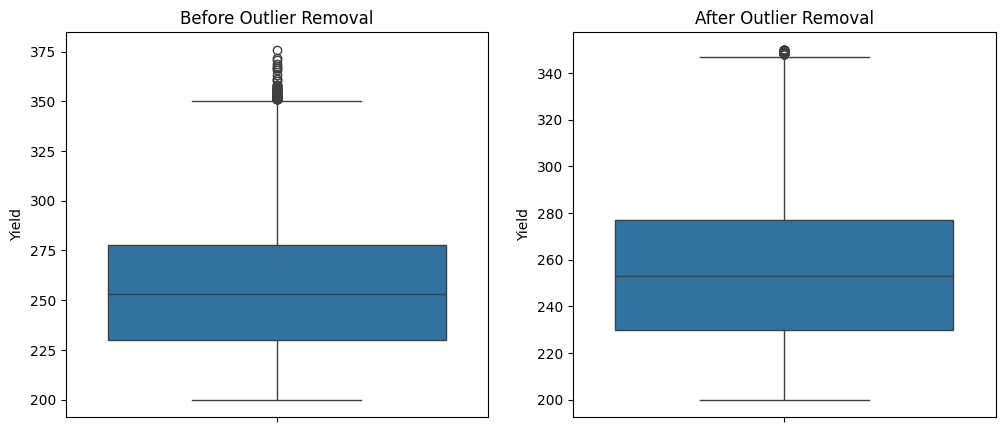

In [ ]:
# Yield numbers before and after removing outlier
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(y=df_before[target_col])
plt.title("Before Outlier Removal")

plt.subplot(1,2,2)
sns.boxplot(y=df_after[target_col])
plt.title("After Outlier Removal")

plt.show()


In [ ]:
import pandas as pd

# Create categorical target (Low, Medium, High)
df_after['Yield_Class'] = pd.qcut(df_after['Yield'], q=3, labels=["Low", "Medium", "High"])

# Check distribution
print(df_after['Yield_Class'].value_counts())


Yield_Class
Low       26969
Medium    26839
High      26109
Name: count, dtype: int64


/tmp/ipython-input-3492768088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['Yield_Class'] = pd.qcut(df_after['Yield'], q=3, labels=["Low", "Medium", "High"])


In [ ]:
# Prepares the data for a classification task
from sklearn.preprocessing import LabelEncoder

# Creating a copy
df_clean = df_after.copy()

# Encode categorical columns
categorical_cols = ['Sunlight_Level', 'Flood_Level', 'Drought_Level']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le   # save encoders if needed for new data


In [ ]:
# Now drop unused columns
X = df_clean.drop(columns=['Yield', 'Yield_Class', 'Farm_ID', 'Planting_Date', 'Harvest_Date'])
y = df_clean['Yield_Class']   #dropping yield column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (63933, 13)  Test shape: (15984, 13)


In [ ]:
# Trains a RandomForestClassifier model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


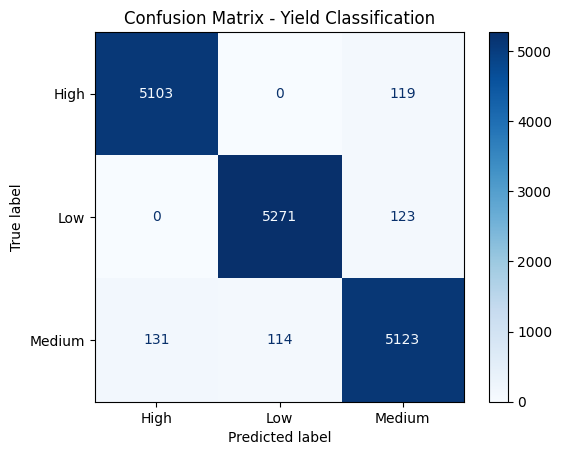

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.98      0.98      5222
         Low       0.98      0.98      0.98      5394
      Medium       0.95      0.95      0.95      5368

    accuracy                           0.97     15984
   macro avg       0.97      0.97      0.97     15984
weighted avg       0.97      0.97      0.97     15984



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Yield Classification")
plt.show()

# Detailed report
print("Classification Report:")
print(classification_report(y_test, y_pred))


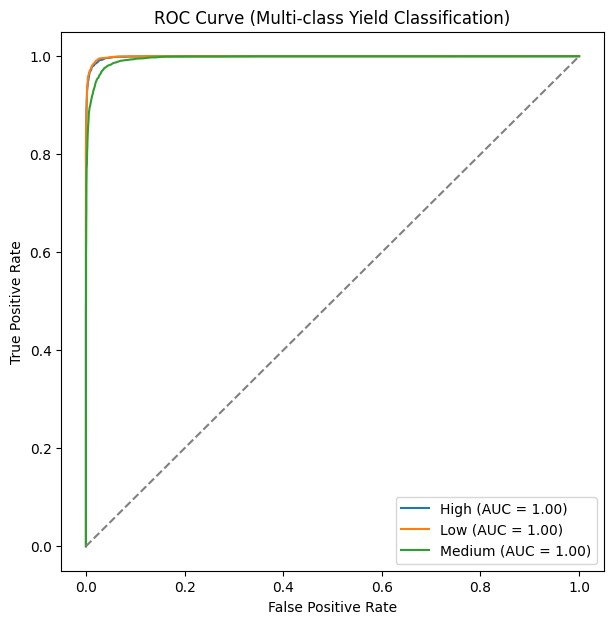

In [ ]:
# Reciever operating characteristic
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=clf.classes_)
y_prob = clf.predict_proba(X_test)   #predicting probabilities

# Calculate ROC and AUC
plt.figure(figsize=(7,7))
for i, class_name in enumerate(clf.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-class Yield Classification)")
plt.legend()
plt.show()


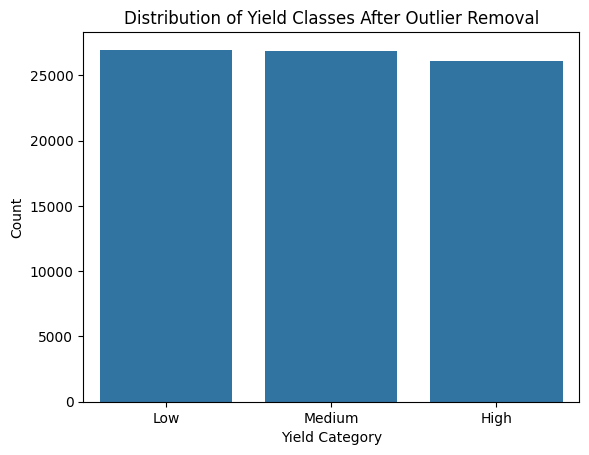

In [ ]:
# Generates a countplot

sns.countplot(x=y, order=y.value_counts().index)
plt.title("Distribution of Yield Classes After Outlier Removal")
plt.xlabel("Yield Category")
plt.ylabel("Count")
plt.show()


In [ ]:
for col in ['Sunlight_Level', 'Flood_Level', 'Drought_Level']:
    print(col, df_clean[col].unique())


Sunlight_Level [1 4 3 2 0]
Flood_Level [3 0 2 1 4]
Drought_Level [3 1 0 2 4]


In [ ]:
# Preparing data for Random Forest Classifier
df_encoded = pd.get_dummies(df_after.drop(columns=['Yield','Yield_Class','Farm_ID','Planting_Date','Harvest_Date']),
                            drop_first=True)

X = df_encoded
y = df_after['Yield_Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Random Forest Classifier for unseen new data
new_data = pd.DataFrame({
    'Growth_Cycle': [150],
    'Sunlight_Hours': [1200],
    'Precipitation': [500],
    'Average_Temperature': [24],
    'Drought_Days': [3],
    'Flood_Days': [1],
    'Soil_Moisture': [30],
    'Soil_pH': [6.5],
    'CO2_Concentration': [400],
    'Harvest_Year': [2023],
    'Sunlight_Level': ['Medium Low'],
    'Flood_Level': ['Medium High'],
    'Drought_Level': ['None']
})

# One-hot encode with same columns as training
new_data_encoded = pd.get_dummies(new_data)
new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)

# Predict
new_pred = clf.predict(new_data_encoded)
print("Predicted Yield Class:", new_pred[0])


Predicted Yield Class: High
